In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install lightning pytorch-lightning==1.9.5
!pip install -U albumentations
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install timm!pip install timm
!pip install openslide-python
!pip install scikit-learn
!pip install seaborn matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 40.9 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.4.0
    Uninstalling pytorch-lightning-2.4.0:
      Successfully uninstalled pytorch-lightning-2.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.20
    Uninstalling albucore-0.0.20:
      Successfully uninstalled albucore-0.0.20
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.21
    Uninstalling albumentations-1.4.21:
      Successfully uninstalled albumentations-1.4.21
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-jkiemtak
  Running command git clone --filter=blob:none --quie

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [3]:
import pandas as pd
import numpy as np
import os
import ast
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer

# ****Eliminar Inconsistencias****

In [4]:
import pandas as pd
import ast

df = pd.read_csv('/kaggle/input/full_df.csv')
df.head(30)

df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)

def find_inconsistencies(df):
    inconsistencies = []


    diagnosis_map = {0: 'N', 1: 'D', 2: 'G', 3: 'C', 4: 'A', 5: 'H', 6: 'M', 7: 'O'}

    for idx, row in df.iterrows():
        diagnosis_values = [row['N'], row['D'], row['G'], row['C'], row['A'], row['H'], row['M'], row['O']]
        active_diagnosis = [diagnosis_map[i] for i, val in enumerate(diagnosis_values) if val == 1]
        expected_label = active_diagnosis[0] if len(active_diagnosis) == 1 else '+'.join(active_diagnosis)

        if row['labels'] != expected_label:
            inconsistencies.append({
                'ID': row['ID'],
                'Label Esperado': expected_label,
                'Label Actual': row['labels'],
                'N': row['N'], 'D': row['D'], 'G': row['G'], 'C': row['C'],
                'A': row['A'], 'H': row['H'], 'M': row['M'], 'O': row['O']
            })

    inconsistency_df = pd.DataFrame(inconsistencies)
    return inconsistency_df

inconsistencies = find_inconsistencies(df)
inconsistencies.head(10)


def remove_significant_inconsistencies(df):
    rows_to_remove = []
    removed_rows_info = []

    diagnosis_map = {0: 'N', 1: 'D', 2: 'G', 3: 'C', 4: 'A', 5: 'H', 6: 'M', 7: 'O'}

    for idx, row in df.iterrows():
        diagnosis_values = [row['N'], row['D'], row['G'], row['C'], row['A'], row['H'], row['M'], row['O']]
        active_diagnosis = [diagnosis_map[i] for i, val in enumerate(diagnosis_values) if val == 1]
        expected_label = active_diagnosis[0] if len(active_diagnosis) == 1 else '+'.join(active_diagnosis)

        if not any(char in expected_label for char in row['labels']):
            rows_to_remove.append(idx)
            removed_rows_info.append({
                'ID': row['ID'],
                'Label Esperado': expected_label,
                'Label Actual': row['labels'],
                'N': row['N'], 'D': row['D'], 'G': row['G'], 'C': row['C'],
                'A': row['A'], 'H': row['H'], 'M': row['M'], 'O': row['O']
            })

    removed_df = pd.DataFrame(removed_rows_info)
    df_cleaned = df.drop(index=rows_to_remove)

    return df_cleaned, removed_df


df_cleaned, removed_rows = remove_significant_inconsistencies(df)
removed_rows.head(10)
df_cleaned.head(30)


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,O,"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
10,11,60,Female,11_left.jpg,11_right.jpg,moderate non proliferative retinopathy，hyperte...,moderate non proliferative retinopathy，hyperte...,0,1,0,0,0,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",11_right.jpg
11,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,M,"[0, 0, 0, 0, 0, 0, 1, 0]",13_right.jpg


In [5]:
# Contar las filas con un 1 para las columnas específicas
columnas_diagnostico = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
conteo_por_columna = df_cleaned[columnas_diagnostico].sum()

# Mostrar los resultados
print("Conteo de filas con un 1 en cada columna:")
print(conteo_por_columna)


Conteo de filas con un 1 en cada columna:
N    2101
D    1871
G     354
C     351
A     297
H     203
M     277
O    1159
dtype: int64


In [6]:
conteo_por_columna = pd.Series({
    'N': 2101,
    'D': 1871,
    'G': 354,
    'C': 351,
    'A': 297,
    'H': 203,
    'M': 277,
    'O': 1159
})

promedio = conteo_por_columna.mean()

print("El promedio de los conteos es:", promedio)


El promedio de los conteos es: 826.625


# **Definimos el dataset personalizado**

In [7]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2


IMG_SIZE = 224  


transform = Compose([
    Resize(IMG_SIZE, IMG_SIZE),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


class OcularDataset(Dataset):
    def __init__(self, df, image_path, label_map, transform=None):
        self.df = df
        self.image_path = image_path
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_path, row['filename'])
        img = cv2.imread(img_path)

        
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = np.zeros((IMG_SIZE, IMG_SIZE, 3))  # Imagen negra en caso de error

        
        if self.transform:
            img = self.transform(image=img)["image"]

        label = self.label_map[row['labels']]
        return img, label


# **Balanceamos el dataset**

In [8]:
from sklearn.utils import resample
from albumentations import HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate
from sklearn.utils import resample
from albumentations import HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomBrightnessContrast, ShiftScaleRotate, 
    RandomResizedCrop, ColorJitter, Normalize, Compose
)
from albumentations.pytorch import ToTensorV2

class_dfs = {label: df_cleaned[df_cleaned['labels'] == label] for label in df_cleaned['labels'].unique()}

target_count = 1200

preprocessed_image_path = '/kaggle/input/preprocessed_images/'



train_transform = Compose([
    RandomResizedCrop(height=IMG_SIZE, width=IMG_SIZE, scale=(0.7, 1.0), ratio=(0.75, 1.333), p=1.0),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.2),  # Agregar Flip Vertical ocasional
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.7),  # Rotaciones y escalas más amplias
    RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),  # Más variabilidad en brillo/contraste
    ColorJitter(p=0.3),  # Simular cambios de color/iluminación
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


test_transform = Compose([
    Resize(IMG_SIZE, IMG_SIZE),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

balanced_dfs = []
for label, class_df in class_dfs.items():
    if len(class_df) > target_count:  
        
        balanced_dfs.append(class_df.sample(n=target_count, random_state=42))
    elif len(class_df) < target_count:  
        
        augmented_samples = []
        for _, row in class_df.iterrows():
            img_path = os.path.join(preprocessed_image_path, row['filename'])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            
            while len(augmented_samples) + len(class_df) < target_count:
                aug_img = train_transform(image=img)["image"].numpy()
                augmented_samples.append({
                    'filename': row['filename'],  
                    'labels': label
                })
        
        
        augmented_df = pd.DataFrame(augmented_samples)
        balanced_dfs.append(pd.concat([class_df, augmented_df]))
    else:
        
        balanced_dfs.append(class_df)


balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)


print("Nueva distribución de etiquetas:")
print(balanced_df['labels'].value_counts())


Nueva distribución de etiquetas:
labels
N    1200
D    1200
O    1200
M    1200
H    1200
C    1200
A    1200
G    1200
Name: count, dtype: int64


# **Realizamos las divisiones**

In [9]:
from sklearn.model_selection import train_test_split

label_map = {label: idx for idx, label in enumerate(balanced_df['labels'].unique())}

train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

preprocessed_image_path = '/kaggle/input/preprocessed_images/'

BATCH_SIZE = 64 

train_dataset = OcularDataset(train_df, preprocessed_image_path, label_map, transform=train_transform)
test_dataset = OcularDataset(test_df, preprocessed_image_path, label_map, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# **Definimos el modelo**

In [10]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  

            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  
        )
        
       
        conv_output_size = 512 * (IMG_SIZE // 16) * (IMG_SIZE // 16) 
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, num_classes)
        )
        

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(label_map)).to(device)


# **Ajustamos optimizadores**

In [11]:
pip install torch-optimizer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW

BASE_LR = 0.00005  # Tasa de aprendizaje inicial
optimizer = optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [13]:
from torch.amp import GradScaler, autocast

scaler = GradScaler()
criterion = nn.CrossEntropyLoss()
 
EPOCHS = 50  

# **Iniciamos el entrenamiento**

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

train_losses = []
val_losses = []
all_labels = []
all_preds = []

for epoch in range(40):
    # Modo de entrenamiento
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with autocast(device_type="cuda"):  
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Modo de validación
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    epoch_labels = []
    epoch_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            with autocast(device_type="cuda"): 
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                epoch_labels.extend(labels.cpu().numpy())
                epoch_preds.extend(predicted.cpu().numpy())

    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / total

    # Guardar etiquetas y predicciones para métricas
    all_labels.extend(epoch_labels)
    all_preds.extend(epoch_preds)

    # Actualizar el scheduler con la métrica de validación
    scheduler.step(val_loss)

    # Mostrar resultados
    print(f"Epoch {epoch + 1}/{40} | Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/40 | Training Loss: 1.3436 | Validation Loss: 0.8740 | Validation Accuracy: 0.6635
Epoch 2/40 | Training Loss: 1.0683 | Validation Loss: 0.8062 | Validation Accuracy: 0.6880
Epoch 3/40 | Training Loss: 0.9957 | Validation Loss: 0.7822 | Validation Accuracy: 0.6948
Epoch 4/40 | Training Loss: 0.9443 | Validation Loss: 0.7738 | Validation Accuracy: 0.6958
Epoch 5/40 | Training Loss: 0.9085 | Validation Loss: 0.7268 | Validation Accuracy: 0.7068
Epoch 6/40 | Training Loss: 0.8835 | Validation Loss: 0.6988 | Validation Accuracy: 0.7260
Epoch 7/40 | Training Loss: 0.8644 | Validation Loss: 0.7289 | Validation Accuracy: 0.7161
Epoch 8/40 | Training Loss: 0.8452 | Validation Loss: 0.6931 | Validation Accuracy: 0.7182
Epoch 9/40 | Training Loss: 0.8252 | Validation Loss: 0.6930 | Validation Accuracy: 0.7125
Epoch 10/40 | Training Loss: 0.8253 | Validation Loss: 0.6797 | Validation Accuracy: 0.7198
Epoch 11/40 | Training Loss: 0.7992 | Validation Loss: 0.6602 | Validation Accuracy: 0.72

# **Resultados**

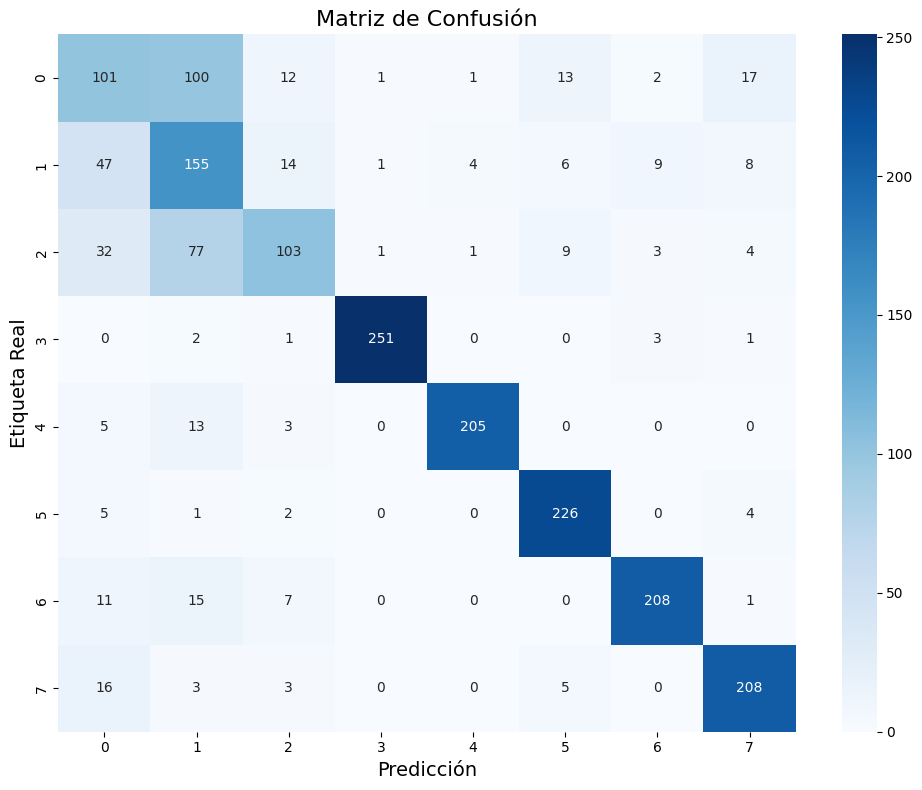

Reporte de Clasificación:
              precision    recall  f1-score   support

           N       0.47      0.41      0.44       247
           D       0.42      0.64      0.51       244
           O       0.71      0.45      0.55       230
           M       0.99      0.97      0.98       258
           H       0.97      0.91      0.94       226
           C       0.87      0.95      0.91       238
           A       0.92      0.86      0.89       242
           G       0.86      0.89      0.87       235

    accuracy                           0.76      1920
   macro avg       0.78      0.76      0.76      1920
weighted avg       0.78      0.76      0.76      1920



In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(predictions, labels, num_classes):
    cm = confusion_matrix(labels, predictions, labels=list(range(num_classes)))
    plt.figure(figsize=(10, 8))  
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))
    plt.title('Matriz de Confusión', fontsize=16)
    plt.xlabel('Predicción', fontsize=14)
    plt.ylabel('Etiqueta Real', fontsize=14)
    plt.tight_layout()
    plt.show()  

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Recolectar predicciones y etiquetas reales
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

plot_confusion_matrix(all_preds, all_labels, num_classes=len(label_map))

print("Reporte de Clasificación:")
print(classification_report(
    all_labels, all_preds, 
    target_names=[str(label) for label in label_map.keys()], 
    zero_division=1
))


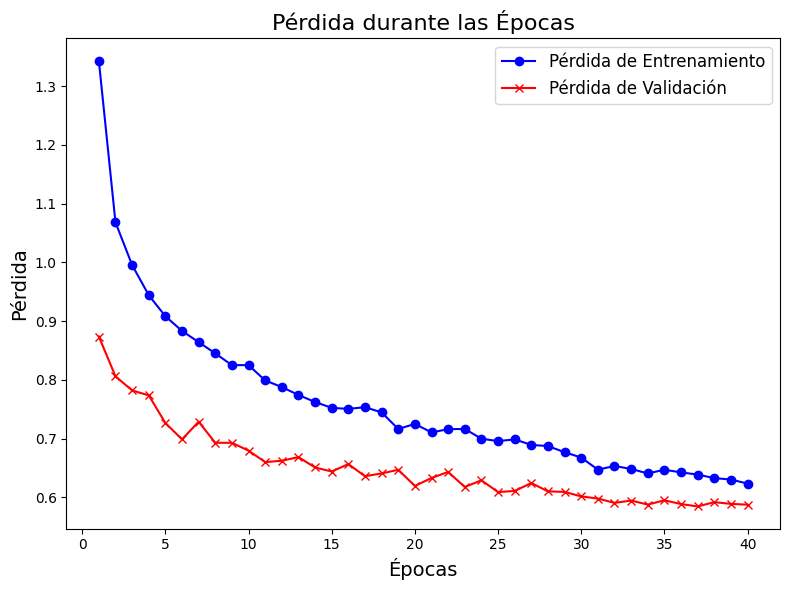

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Pérdida de Entrenamiento', color='blue', linestyle='-', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Pérdida de Validación', color='red', linestyle='-', marker='x')
plt.title('Pérdida durante las Épocas', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Pérdida', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


**NOTA: Los resultados mostrados pueden variar minimamente con respecto a los vistos en las diapositivas, ya que se probó por última vez que el notebook se ejecutara completamente de forma correcta, con la función "RUN ALL" de Kaggle.**